# Examine uncertainty and model prediction error
In order to assess the uncertainty of a model's predictions, there are a few key evaluations that could be made such as examining the variability of the model prediction or the model prediction errors. Another such evaluation is the Applicability Domain Index or ADI. The ADI value calculated by AMPL is a metric of how far an 'unseen' compound you're making predictions on is from the training data. While `z-score` ADI examines the entire training dataset, the `local density` ADI looks at the compounds in the training dataset closest to the unseen compound. The distances calculated are based on the feature vectors which is model-specific, depending on how you trained your model.

The `z-score` AD is calculated as the following:
1. For each compound in the training set, find the mean value of the distance to its `k` nearest neighbors using `euclidean` distance.
2. Calculate the distribution (mean and standard deviation) of all the `k`-nearest-neighbor average distances for the training dataset.
3. For your unseen compound, find the mean distance to the `k` nearest neighbors in the training set.
4. Use the unseen mean distance to calculate a `z-score` defined as:
<center>$\frac{mean(unseenkdists)-mean(traindists)}{std(traindists)}$

As with regular statistics, a `z-score` of ~3 or greater means ~99.7% of the compounds in the training set are not this far away from their nearest neighbors.

The `local density` AD is defined as "compare the distance between the unseen object and its k nearest neighbors in the training set to the distance between these k nearest neighbors and _their_ k nearest neighbors in the training set. Return the distance ratio. Greater than 1 means the pred data is far from the domain." 

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from atomsci.ddm.pipeline import compare_models as cmp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp

Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get model information

In [11]:
import importlib
importlib.reload(cmp)
perf_df=cmp.get_filesystem_perf_results('dataset/SLC6A3_models/', expand=False, pred_type='classification')
perf_df.columns

Found data for 48 models under dataset/SLC6A3_models/


Index(['model_uuid', 'model_path', 'ampl_version', 'model_type', 'dataset_key',
       'features', 'splitter', 'split_strategy', 'split_uuid',
       'model_score_type', 'feature_transform_type', 'weight_transform_type',
       'model_choice_score', 'best_train_roc_auc_score',
       'best_train_prc_auc_score', 'best_train_precision',
       'best_train_recall_score', 'best_train_num_compounds',
       'best_train_accuracy_score', 'best_train_bal_accuracy',
       'best_train_npv', 'best_train_matthews_cc', 'best_train_kappa',
       'best_train_cross_entropy', 'best_train_confusion_matrix',
       'best_valid_roc_auc_score', 'best_valid_prc_auc_score',
       'best_valid_precision', 'best_valid_recall_score',
       'best_valid_num_compounds', 'best_valid_accuracy_score',
       'best_valid_bal_accuracy', 'best_valid_npv', 'best_valid_matthews_cc',
       'best_valid_kappa', 'best_valid_cross_entropy',
       'best_valid_confusion_matrix', 'best_test_roc_auc_score',
       'best_test_

In [12]:
# all models
perf_df[['model_uuid','features','weight_transform_type','model_score_type','best_valid_bal_accuracy',
         'best_valid_confusion_matrix','model_parameters_dict']].sort_values('best_valid_bal_accuracy', ascending=False).head(5)

,model_uuid,features,weight_transform_type,model_score_type,best_valid_bal_accuracy,best_valid_confusion_matrix,model_parameters_dict
13,7832b9e5-c7e7-4b79-9b8c-7daacd676f36,ecfp,None,mcc,0.760204,"[[[215, 30], [10, 18]]]","{""best_epoch"": 22, ""dropouts"": [0.3, 0.3], ""la..."
10,948f8730-5f52-44e2-8eaa-3dbb9ed00c01,ecfp,None,mcc,0.754592,"[[[221, 24], [11, 17]]]","{""best_epoch"": 21, ""dropouts"": [0.3, 0.3], ""la..."
17,68c7a414-cf1c-4a9a-94aa-fe7ceca88db8,ecfp,None,mcc,0.754082,"[[[212, 33], [10, 18]]]","{""best_epoch"": 11, ""dropouts"": [0.3, 0.3], ""la..."
3,340b303c-c152-482d-a876-5a0dd3318d66,ecfp,None,mcc,0.752551,"[[[220, 25], [11, 17]]]","{""best_epoch"": 17, ""dropouts"": [0.3, 0.3], ""la..."
6,af5e19e9-760e-4ec0-b7d3-3458f39ba9a1,ecfp,None,mcc,0.742857,"[[[224, 21], [12, 16]]]","{""best_epoch"": 23, ""dropouts"": [0.3, 0.3], ""la..."


In [13]:
# rdkit models only
perf_df[(perf_df.features=='rdkit_raw')&(perf_df.model_score_type=='bal_accuracy')][['model_uuid','features','weight_transform_type',
                                        'model_score_type','best_valid_bal_accuracy','best_valid_confusion_matrix',
                                        'model_parameters_dict']].sort_values('best_valid_bal_accuracy', ascending=False).head(5)

,model_uuid,features,weight_transform_type,model_score_type,best_valid_bal_accuracy,best_valid_confusion_matrix,model_parameters_dict
46,1e2d98cf-497a-4340-ba8c-a6e2fb90d55d,rdkit_raw,balancing,bal_accuracy,0.729592,"[[[235, 10], [14, 14]]]","{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf..."
47,64843a96-208d-4d1e-a559-2edf1b8b695a,rdkit_raw,None,bal_accuracy,0.628061,"[[[229, 16], [19, 9]]]","{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf..."


In [14]:
ecfp_model=perf_df[perf_df.model_uuid=='7832b9e5-c7e7-4b79-9b8c-7daacd676f36']
rdkit_model=perf_df[perf_df.model_uuid=='64843a96-208d-4d1e-a559-2edf1b8b695a']
bal_rdkit=perf_df[perf_df.model_uuid=='1e2d98cf-497a-4340-ba8c-a6e2fb90d55d']

## Prepare dataset to predict on
- it is useful to merge the split information with the dataset in order to make additional plots later.

In [54]:
dataset_file = 'dataset/SLC6A3_classif_pKi_ge_8.csv'
data=pd.read_csv(dataset_file)
data.head()

,compound_id,base_rdkit_smiles,relation,avg_pKi,active
0,CHEMBL2113217,C#CCC(C(=O)c1ccc(C)cc1)N1CCCC1,NaN,5.636388,0
1,CHEMBL220765,C#CCN1CC[C@@H](Cc2ccc(F)cc2)C[C@@H]1CCCNC(=O)N...,NaN,6.206908,0
2,CHEMBL1945248,C#CCN1[C@H]2CC[C@@H]1[C@@H](C(=O)OC)[C@@H](c1c...,NaN,7.849858,0
3,CHEMBL1479,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,NaN,5.264721,0
4,CHEMBL691,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(O)ccc4[C@H]3C...,NaN,6.352617,0


In [55]:
split_file = f'dataset/SLC6A3_classif_pKi_ge_8_train_valid_test_scaffold_{ecfp_model.split_uuid.iloc[0]}.csv'
split=pd.read_csv(split_file)
display(split.head(2))
split.subset.value_counts()

,cmpd_id,subset,fold
0,CHEMBL2113217,train,0
1,CHEMBL220765,train,0


subset
train    1273
valid     273
test      273
Name: count, dtype: int64

In [56]:
data=data.merge(split, left_on='compound_id', right_on='cmpd_id', how='left')
data=data.drop(columns='cmpd_id')

## Make predictions with ADI
Here we use the `predict_from_model_file` function from the `predict_from_model` module built into `AMPL`. We can include the optional arguments in the function call to get the ADI:

|Arg|Definition|
|---|---|
|`AD_method`|`z_score` or `local_density` (default `None`).|
|`k`|Number of nearest neighbors to use when calculating the ADI (default 5).|
|`dist_metric`|Distance metric to use when calculating nearest neighbor distances. Options are `cityblock`, `cosine`, `euclidean`, `jaccard`, and `manhattan`. If binary features such as fingerprints are used in model, 'jaccard' (equivalent to Tanimoto distance) maybe a better choice than the other metrics which operate on continuous features (default `euclidean`).|
|`max_train_records_for_AD`|Maximum number of training data rows to use for AD calculation. Note that the AD calculation time scales as the square of the number of training records used. If the training dataset is larger than `max_train_records_for_AD`, a random sample of rows with this size is used instead for the AD calculations (default 1000).|

Since this model is made with ECFP features, we will use the jaccard distance metric. We will also use the full training dataset to calculated the ADI.

In [57]:
pred_df=pfm.predict_from_model_file(ecfp_model.model_path.iloc[0], input_df=data, response_col='active', 
                                    smiles_col='base_rdkit_smiles', dont_standardize=True, 
                                    AD_method='z_score', dist_metric='jaccard', k=5, max_train_records_for_AD=1273)
pred_df.head(2)

2024-04-12 18:02:04,323 dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_7832b9e5-c7e7-4b79-9b8c-7daacd676f36.tar.gz, 1.6.1
2024-04-12 18:02:04,324 Version compatible check: dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_7832b9e5-c7e7-4b79-9b8c-7daacd676f36.tar.gz version = "1.6", AMPL version = "1.6"


['/tmp/tmpao7ohzo4/best_model/checkpoint1.pt']
/tmp/tmpao7ohzo4/best_model/checkpoint1.pt


/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,compound_id,base_rdkit_smiles,relation,avg_pKi,active,subset,fold,active_actual,active_prob,active_pred,AD_index
0,CHEMBL2113217,C#CCC(C(=O)c1ccc(C)cc1)N1CCCC1,NaN,5.636388,0,train,0,0,0.012962,0,0.911143
1,CHEMBL220765,C#CCN1CC[C@@H](Cc2ccc(F)cc2)C[C@@H]1CCCNC(=O)N...,NaN,6.206908,0,train,0,0,0.004658,0,0.000001


In the outputted dataframe, we can see the following new columns:
|Column|Description|
|---|---|
|`active_actual`|ground truth data|
|`active_prob`|"probability" of guess, or softmax output: if this value is <0.5 we will predict 0 and if >0.5 we will predict 1|
|`active_pred`|The class predictions|
|`AD_index`|The ADI for the given compound|

We will now add additional columns to calculated the `active_err` (absolute value of actual-predicted) and `active_uncertainty`, which is based off the softmax output. It ranges from 0 to 0.5 and the higher the value, the more uncertain the prediction.

In [61]:
pred_df['active_err']=abs(pred_df.active-pred_df.active_pred)
pred_df['active_err']=np.where(pred_df.active_err==0, 'Correct', 'Wrong')
pred_df['active_uncertainty']=np.where(pred_df.active_pred==1, 1-pred_df.active_prob, pred_df.active_prob)
pred_df=pred_df.sort_values('active_err').reset_index(drop=True) # this affects scatter plot plotting order
pred_df.head()

,compound_id,base_rdkit_smiles,relation,avg_pKi,active,subset,fold,active_actual,active_prob,active_pred,AD_index,active_err,active_uncertainty
0,CHEMBL2113217,C#CCC(C(=O)c1ccc(C)cc1)N1CCCC1,NaN,5.636388,0,train,0,0,0.012962,0,0.911143,Correct,0.012962
1,CHEMBL250689,CC(=O)c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@...,NaN,6.309804,0,test,0,0,0.049261,0,2.241279,Correct,0.049261
2,CHEMBL249854,CC(=O)c1sc(NC(=O)N[C@@H]2CN(C(C)=O)CC[C@H]2CN2...,NaN,5.187087,0,test,0,0,0.010036,0,3.945324,Correct,0.010036
3,CHEMBL566830,CC(C(=O)c1cccc(Cl)c1)N(C)C,NaN,5.383735,0,train,0,0,0.038055,0,0.610202,Correct,0.038055
4,CHEMBL578612,CC(C(=O)c1cccc(Cl)c1)N(C)C(C)(C)C,NaN,5.193820,0,train,0,0,0.036722,0,1.138452,Correct,0.036722


## Visualize ADI with predictions
Since this is a classification model, we look at the `active_uncertainty` value instead of the `active_pred` to see the data more spread out and understand the relationship between the uncertainty of the classification, the AD_index (a measure of distance from training data), and the error (whether the data point was classified correctly).

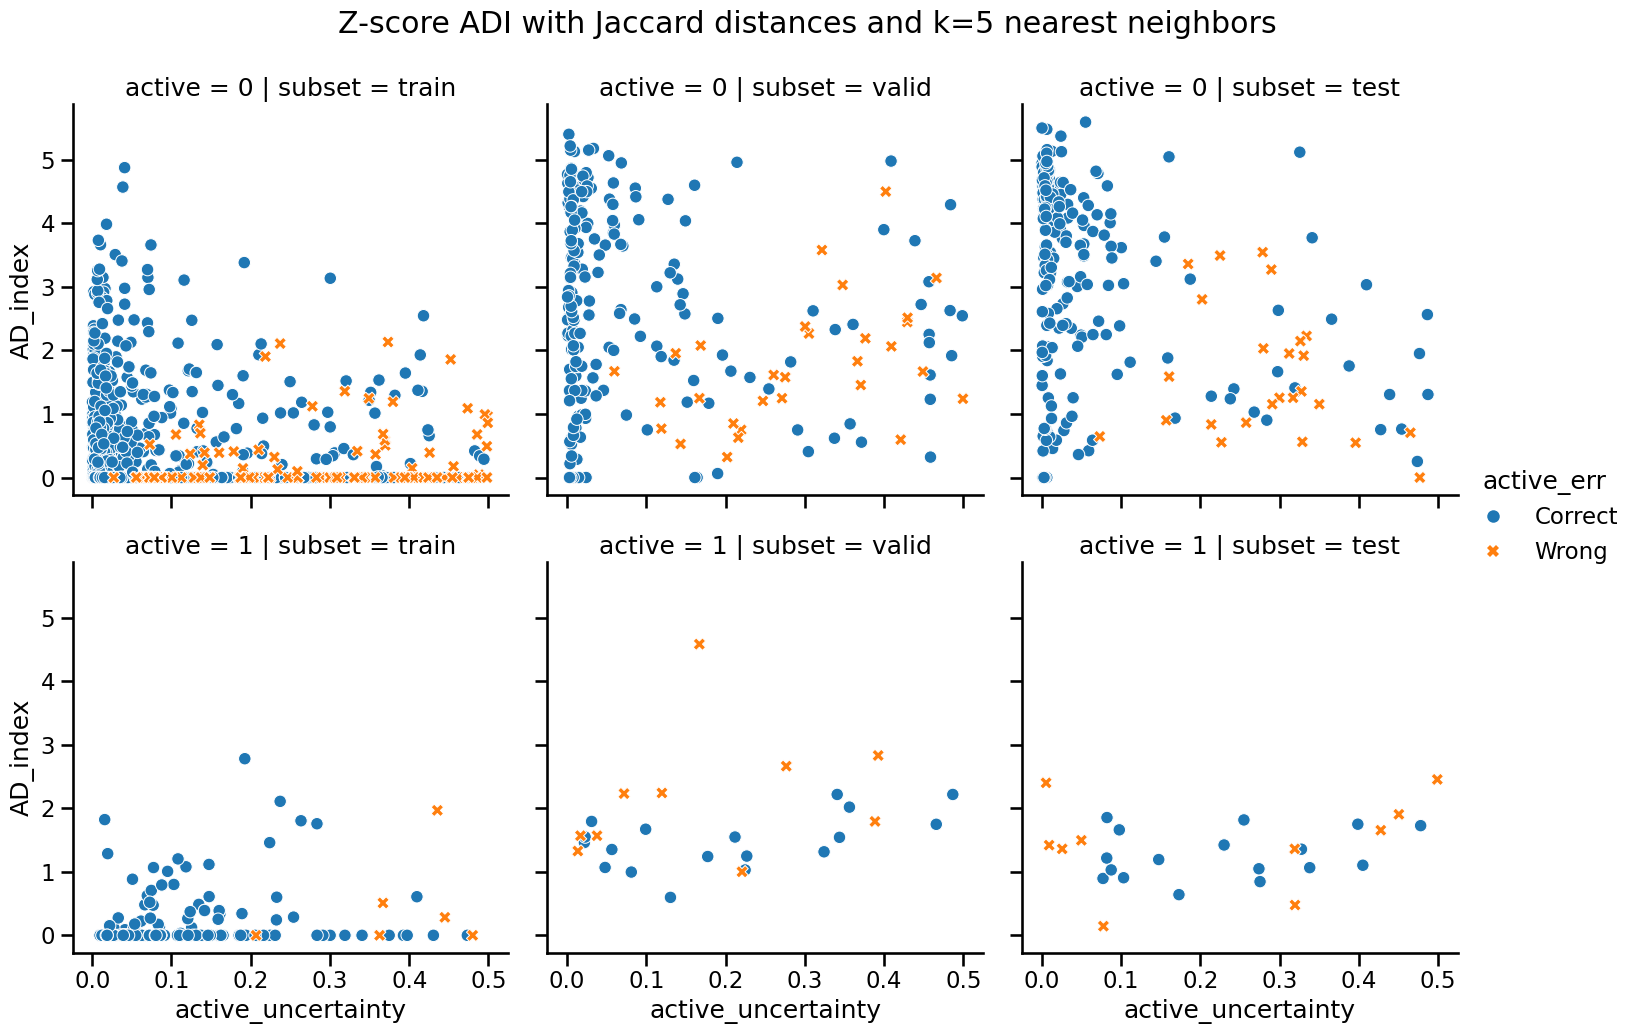

In [62]:
sns.set_context('talk')
g=sns.relplot(data=pred_df, x='active_uncertainty',y='AD_index', hue='active_err', style="active_err", row='active',col='subset', col_order=['train','valid','test'])
g.fig.suptitle('Z-score ADI with Jaccard distances and k=5 nearest neighbors', y=1.04);

Since this model used a scaffold split, it makes sense that the ADI values for the validation and test sets are higher than those in the training dataset.  In the majority class (0), we can see that the wrong guesses have relatively higher uncertainty, but it's still pretty mixed. In the minority validation set (class 1), the ADI is higher for the incorrect predictions. Otherwise, the orange values that were guessed wrongly are fairly well-distributed across the range of ADI's and active_uncertainty, indicating that these metrics do not aid us in understanding how the model went wrong.

Let's compare the Z-score ADI with the local_density ADI:

2024-04-12 18:04:15,922 dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_7832b9e5-c7e7-4b79-9b8c-7daacd676f36.tar.gz, 1.6.1
2024-04-12 18:04:15,923 Version compatible check: dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_7832b9e5-c7e7-4b79-9b8c-7daacd676f36.tar.gz version = "1.6", AMPL version = "1.6"


['/tmp/tmpi3xf11jx/best_model/checkpoint1.pt']
/tmp/tmpi3xf11jx/best_model/checkpoint1.pt


/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


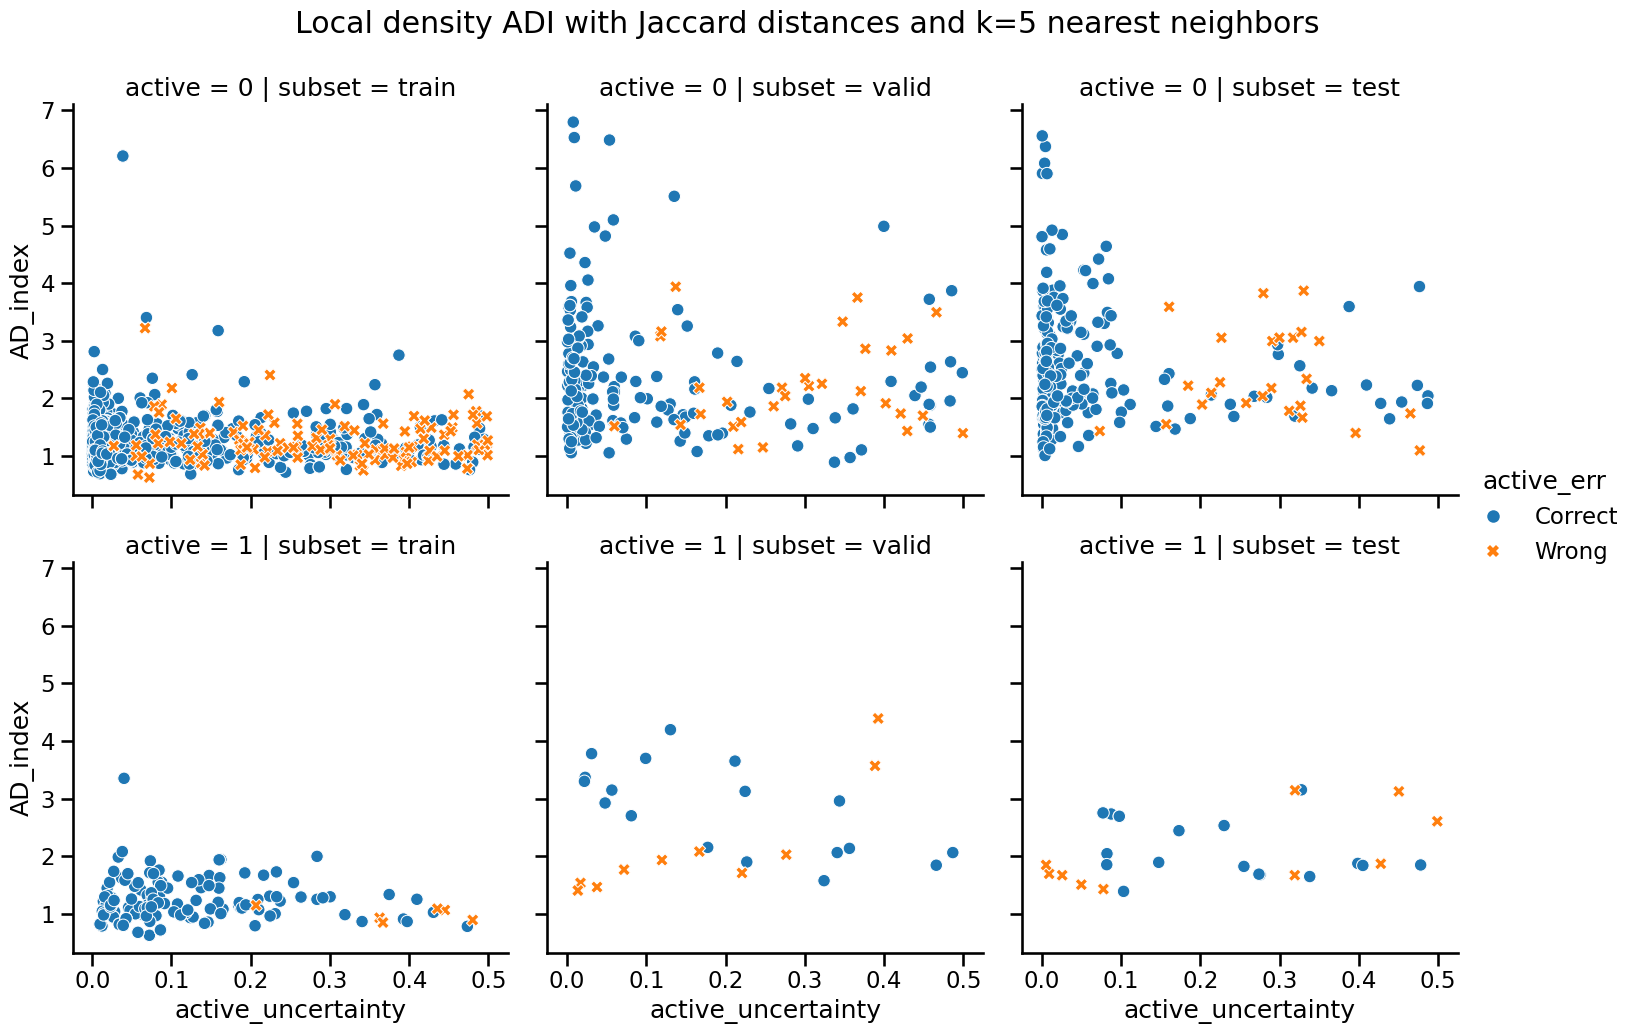

In [63]:
pred_df=pfm.predict_from_model_file(ecfp_model.model_path.iloc[0], input_df=data, response_col='active', 
                                    smiles_col='base_rdkit_smiles', dont_standardize=True, 
                                    AD_method='local_density', k=5, dist_metric='jaccard', max_train_records_for_AD=1273)

pred_df['active_err']=abs(pred_df.active-pred_df.active_pred)
pred_df['active_err']=np.where(pred_df.active_err==0, 'Correct', 'Wrong')
pred_df['active_uncertainty']=np.where(pred_df.active_pred==1, 1-pred_df.active_prob, pred_df.active_prob)
pred_df=pred_df.sort_values('active_err').reset_index(drop=True)

g=sns.relplot(data=pred_df, x='active_uncertainty',y='AD_index', hue='active_err', style="active_err", row='active',col='subset', col_order=['train','valid','test'])
g.fig.suptitle('Local density ADI with Jaccard distances and k=5 nearest neighbors', y=1.04);

There are slight differences between local density and z-score ADI's for this dataset. Reflecting the underlying mathematics, the range of z-score ADI goes from 0-infinity, with the majority of the training data ranging from ~0-3. In contrast, most of the local_density ADI's hover around 1 in the training set, indicating that the average distance between any two given points is about equal. In both methods, we can see that the scaffold split results in ADI values that are higher than in the training set.

However, we still see no clear trend between ADI or active_prob that would indicate that these measures are valuable for helping us interpret the model. Additional choices could be made with K and the distance metric that might make things more clear.

## Visualize uncertainty of an RDKit featurized model
- Since we are making predictions on the actual training dataset, we know it's already featurized. To save time, we can directly pass in the featurized dataset instead of letting the pipeline re-featurize it. We include the flag `is_featurized=True` in the function call.

In [64]:
rdkit_model

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,...,best_test_num_compounds,best_test_accuracy_score,best_test_bal_accuracy,best_test_npv,best_test_matthews_cc,best_test_kappa,best_test_cross_entropy,best_test_confusion_matrix,model_parameters_dict,feat_parameters_dict
47,64843a96-208d-4d1e-a559-2edf1b8b695a,dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_...,1.6.1,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,train_valid_test,cd1a172a-125b-4812-b70b-5eae583d5ac3,bal_accuracy,...,273,0.886447,0.588776,0.914729,0.23639,0.223507,0.35883,"[[[236, 9], [22, 6]]]","{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...",{}


In [65]:
input_df=pd.read_csv('dataset/scaled_descriptors/SLC6A3_classif_pKi_ge_8_with_rdkit_raw_descriptors.csv')
split=pd.read_csv(f'dataset/SLC6A3_classif_pKi_ge_8_train_valid_test_scaffold_{rdkit_model.split_uuid.iloc[0]}.csv')
input_df=input_df.merge(split, left_on='compound_id', right_on='cmpd_id', how='left')
input_df=input_df.drop(columns='cmpd_id')
input_df.head(2)

,compound_id,base_rdkit_smiles,active,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,subset,fold
0,CHEMBL609023,CCOCC[C@]1(c2ccc(Cl)c(Cl)c2)[C@@H]2CNC[C@@H]21,0,8.930783,-4.232599,8.930783,0.459490,0.840316,300.229,281.077,...,0,0,0,0,0,0,0,0,train,0
1,CHEMBL599242,CSC[C@@H]1[C@H]2CNC[C@]21c1ccc(Cl)c(Cl)c1,0,8.884409,-3.404911,8.884409,0.290788,0.914059,288.243,273.123,...,0,0,0,0,0,0,0,0,train,0


In [66]:
input_df.subset.value_counts()

subset
train    1273
test      273
valid     273
Name: count, dtype: int64

2024-04-12 18:04:50,500 dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_64843a96-208d-4d1e-a559-2edf1b8b695a.tar.gz, 1.6.1
2024-04-12 18:04:50,501 Version compatible check: dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_64843a96-208d-4d1e-a559-2edf1b8b695a.tar.gz version = "1.6", AMPL version = "1.6"
/home/apaulson/repos/AMPL_umbrella/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
/home/apaulson/repos/AMPL_umbrella/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


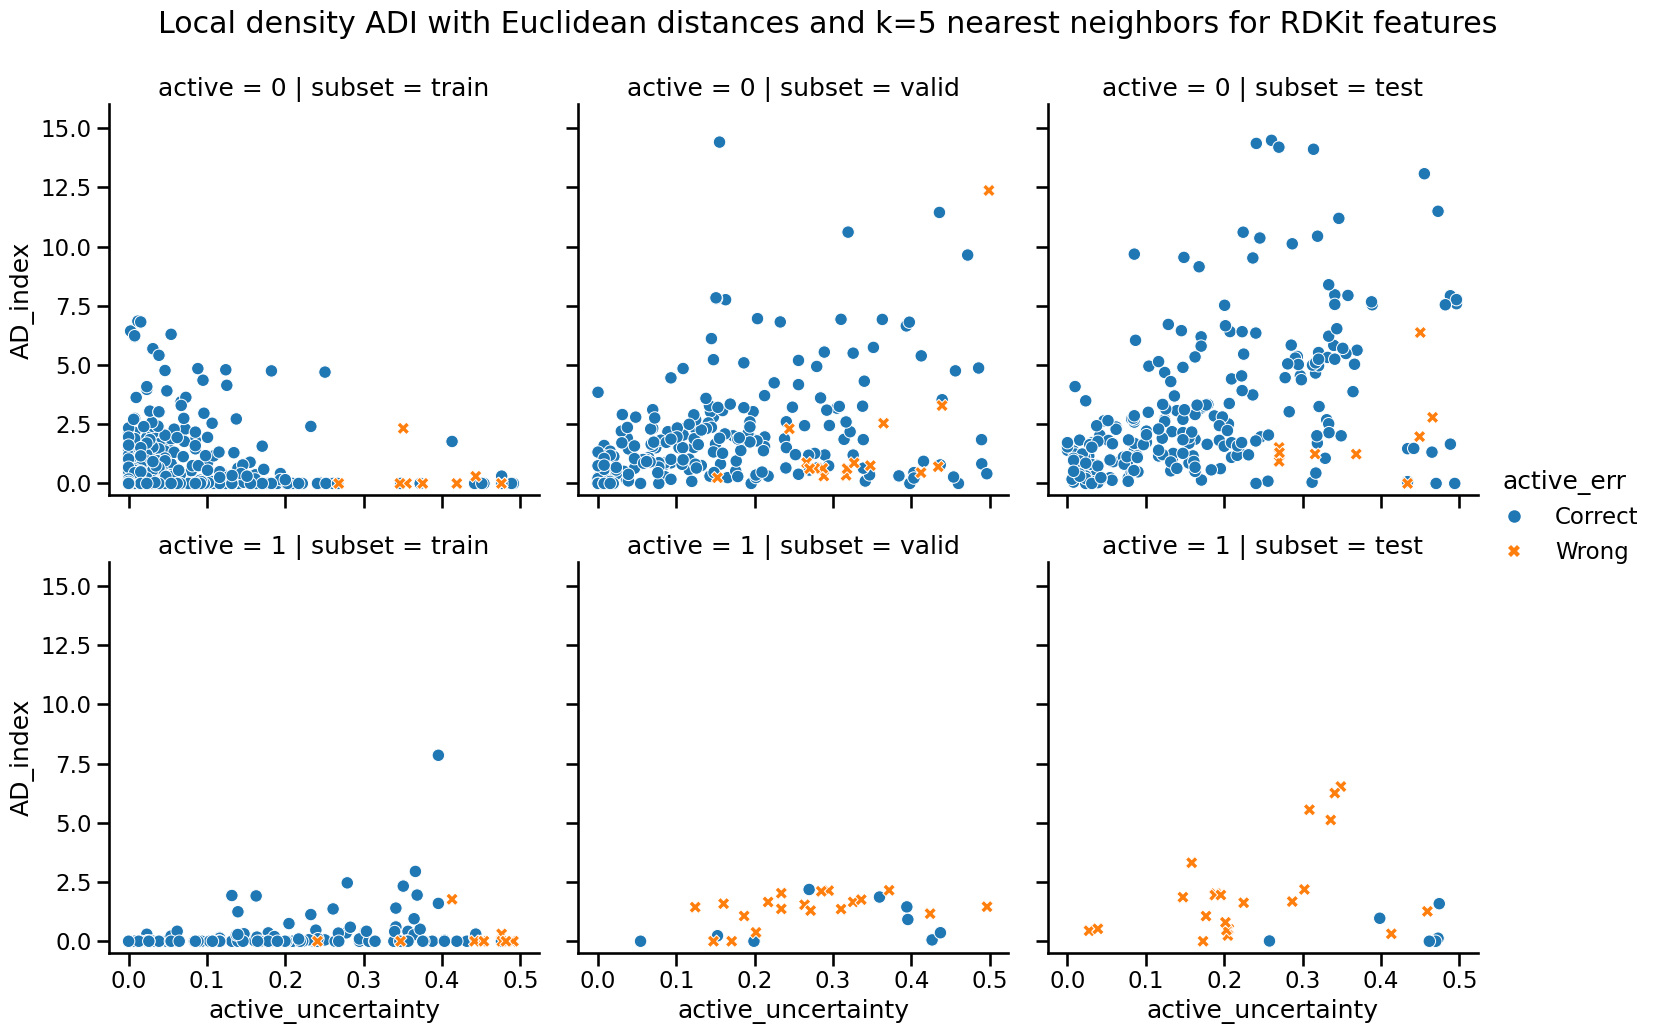

In [67]:
pred_df=pfm.predict_from_model_file(rdkit_model.model_path.iloc[0], input_df, response_col='active',
                                    smiles_col='base_rdkit_smiles', dont_standardize=True, 
                                    is_featurized=True, 
                                    AD_method='local density', dist_metric='euclidean', k=5, max_train_records_for_AD=1273)
pred_df['active_err']=abs(pred_df.active-pred_df.active_pred)
pred_df['active_err']=np.where(pred_df.active_err==0, 'Correct', 'Wrong')
pred_df['active_uncertainty']=np.where(pred_df.active_pred==1, 1-pred_df.active_prob, pred_df.active_prob)
pred_df=pred_df.sort_values(['active_err']).reset_index(drop=True)

g=sns.relplot(data=pred_df, x='active_uncertainty',y='AD_index', hue='active_err', style="active_err", row='active',col='subset', col_order=['train','valid','test'])
g.set(ylim=(-.5, 16))
g.fig.suptitle('Local density ADI with Euclidean distances and k=5 nearest neighbors for RDKit features', y=1.04);

Here we can see a few interesting things: most of the “far” compounds with high ADI are in the majority class, so a “dumb” classifier gets them right. But for the minority class test set, the dumb classifier is very certain that it’s guessing the correct thing, even though its most certain guesses were all wrong. So, the uncertain compounds are not the same ones that are far away from the training set. Therefore, ADI is not a good measure of whether this model can generalize to new compounds.

From this information specifically, I would not trust this model to be able to effectively classify new compounds into the majority class. I would attempt to train the model again with the balancing transformer and look at how the uncertainty changes:

In [68]:
bal_rdkit.model_path.iloc[0]

'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_1e2d98cf-497a-4340-ba8c-a6e2fb90d55d.tar.gz'

In [69]:
input_df=pd.read_csv('dataset/scaled_descriptors/SLC6A3_classif_pKi_ge_8_with_rdkit_raw_descriptors.csv')
split=pd.read_csv(f'dataset/SLC6A3_classif_pKi_ge_8_train_valid_test_scaffold_{bal_rdkit.split_uuid.iloc[0]}.csv')
input_df=input_df.merge(split, left_on='compound_id', right_on='cmpd_id', how='left')
input_df=input_df.drop(columns='cmpd_id')

2024-04-12 18:05:07,664 dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_1e2d98cf-497a-4340-ba8c-a6e2fb90d55d.tar.gz, 1.6.1
2024-04-12 18:05:07,665 Version compatible check: dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8_model_1e2d98cf-497a-4340-ba8c-a6e2fb90d55d.tar.gz version = "1.6", AMPL version = "1.6"
/home/apaulson/repos/AMPL_umbrella/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
/home/apaulson/repos/AMPL_umbrella/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


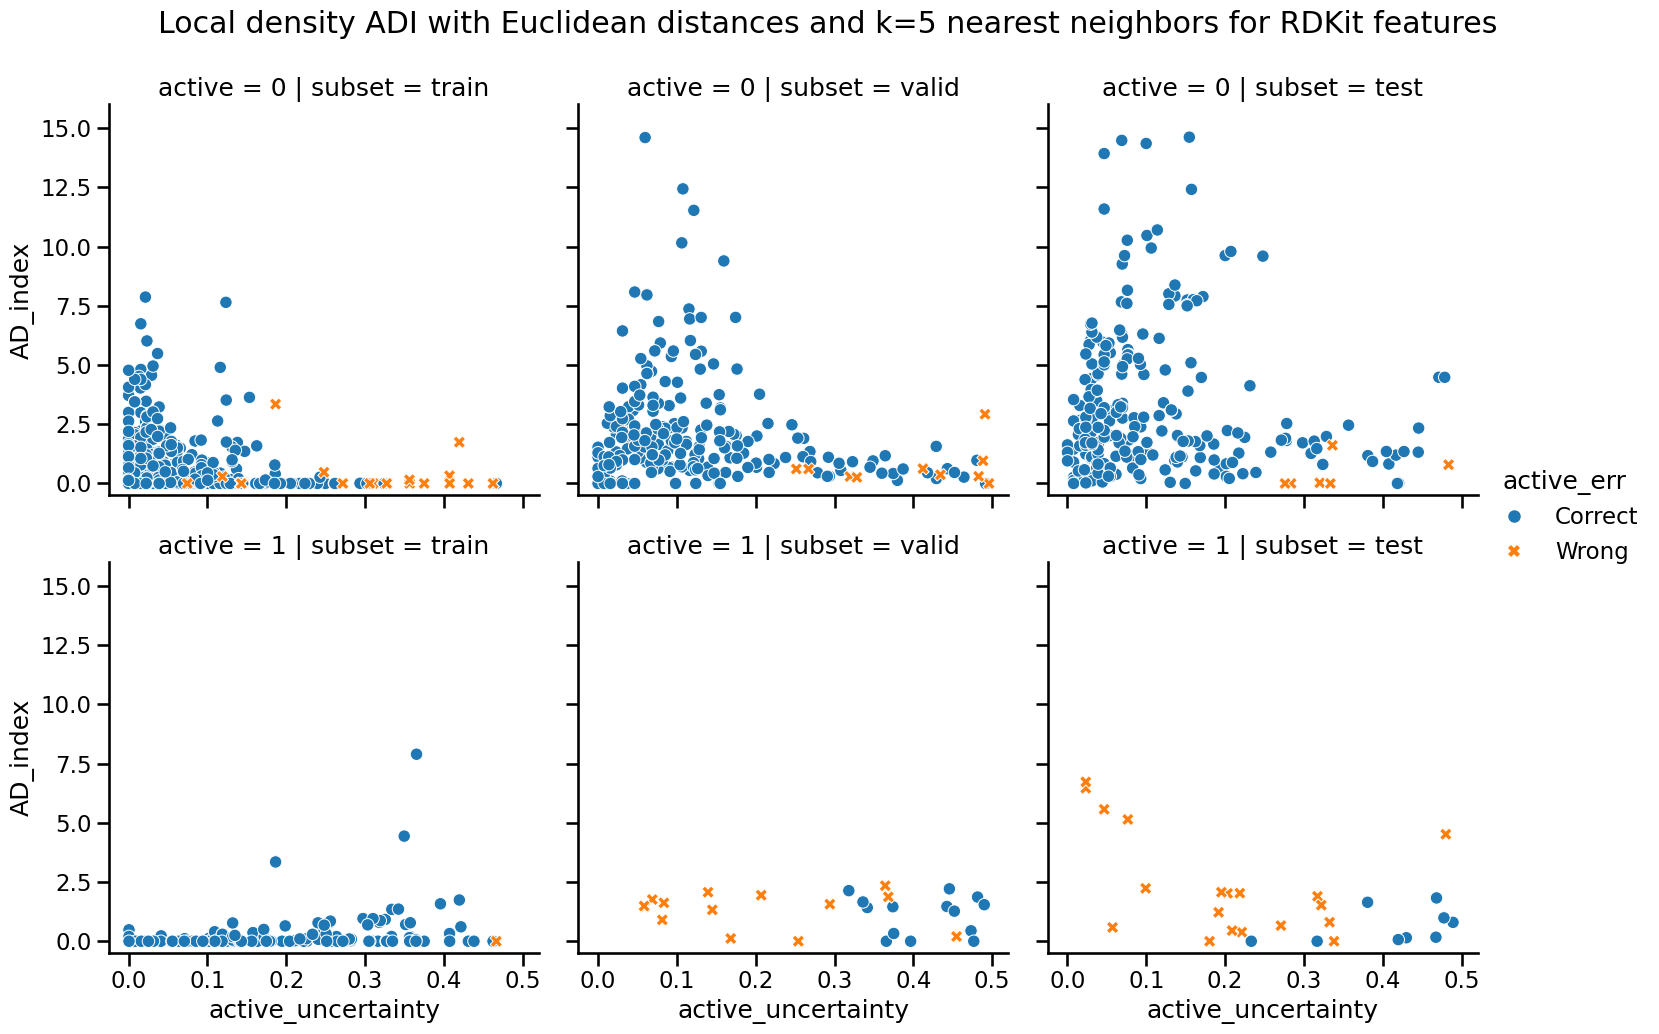

In [70]:
pred_df=pfm.predict_from_model_file(bal_rdkit.model_path.iloc[0], input_df, smiles_col='base_rdkit_smiles', dont_standardize=True,
                                    is_featurized=True, 
                                    AD_method='local density', dist_metric='euclidean', k=5, max_train_records_for_AD=1273)
pred_df['active_err']=abs(pred_df.active-pred_df.active_pred)
pred_df['active_err']=np.where(pred_df.active_err==0, 'Correct', 'Wrong')
pred_df['active_uncertainty']=np.where(pred_df.active_pred==1, 1-pred_df.active_prob, pred_df.active_prob)
pred_df=pred_df.sort_values(['active_err']).reset_index(drop=True)

g=sns.relplot(data=pred_df, x='active_uncertainty',y='AD_index', hue='active_err', style="active_err", row='active',col='subset', col_order=['train','valid','test'])
g.set(ylim=(-.5, 16))
g.fig.suptitle('Local density ADI with Euclidean distances and k=5 nearest neighbors for RDKit features', y=1.04);

Interestingly, the balancing classifier serves to decrease the uncertainty and accuracy of the majority class predictions, but this comes at the expense of accuracy for the minority class predictions. In fact, almost all the wrong predictions for the minority class 1 have lower uncertainty than their correct counterparts. This indicates that using the balancing transformer has pushed the model in the wrong direction, despite the improved metrics.

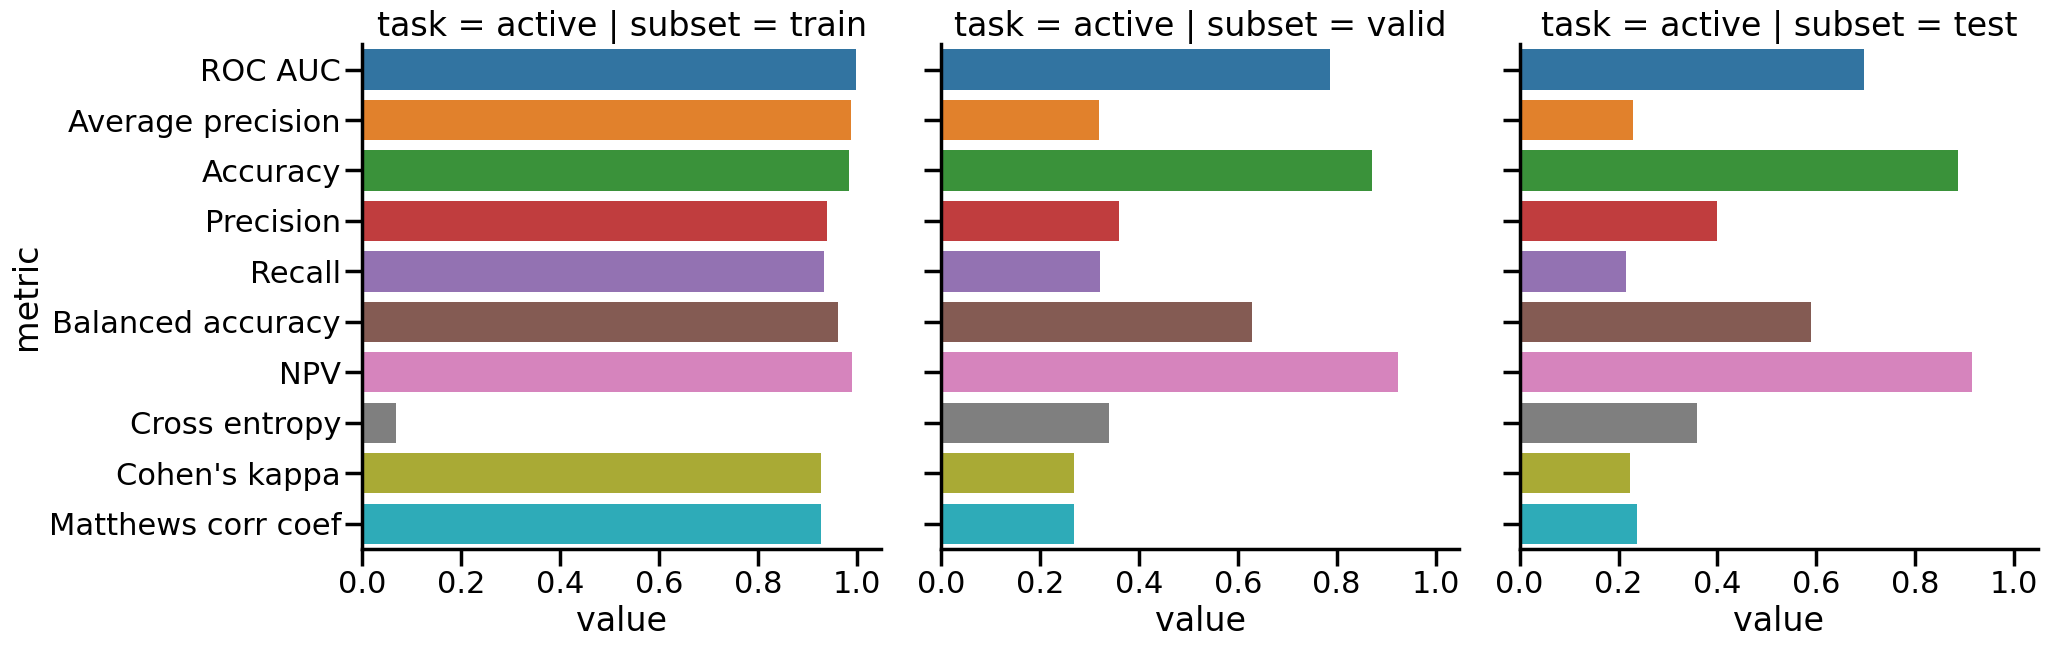

In [73]:
pp.plot_model_metrics(rdkit_model.model_path.iloc[0])

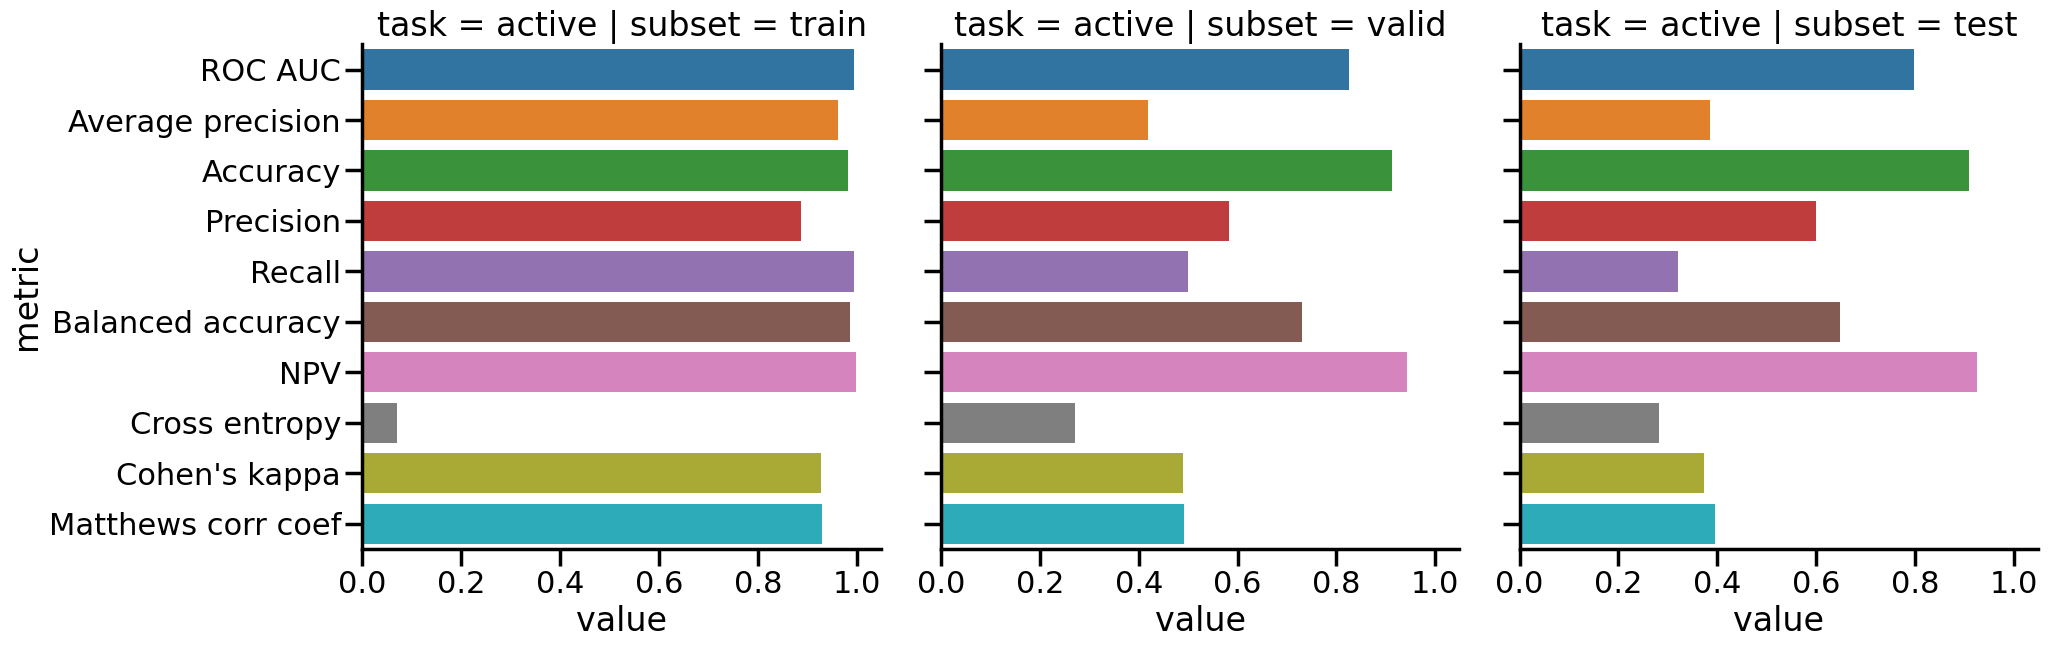

In [74]:
pp.plot_model_metrics(bal_rdkit.model_path.iloc[0])

## Visualize a regression model

In [79]:
regression_model_path="dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz"
model_data="dataset/SLC6A3_Ki_curated.csv"
split_uuid='c35aeaab-910c-4dcf-8f9f-04b55179aa1a'
split_type='scaffold'
features='ecfp'

In [80]:
data=pd.read_csv(model_data)
split=pd.read_csv(f'dataset/SLC6A3_Ki_curated_train_valid_test_{split_type}_{split_uuid}.csv')
data=data.merge(split, left_on='compound_id', right_on='cmpd_id', how='left')
data=data.drop(columns='cmpd_id')
data.head(2)

,compound_id,base_rdkit_smiles,relation,avg_pKi,subset,fold
0,CHEMBL2113217,C#CCC(C(=O)c1ccc(C)cc1)N1CCCC1,NaN,5.636388,train,0
1,CHEMBL220765,C#CCN1CC[C@@H](Cc2ccc(F)cc2)C[C@@H]1CCCNC(=O)N...,NaN,6.206908,train,0


In [81]:
pred_df=pfm.predict_from_model_file(regression_model_path, data, response_col='avg_pKi',
                                    smiles_col='base_rdkit_smiles', dont_standardize=True,
                                    is_featurized=False, 
                                    AD_method='z_score', dist_metric='jaccard', k=5, max_train_records_for_AD=1273)
pred_df.head(2)

2024-04-12 18:07:32,587 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
2024-04-12 18:07:32,588 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"
/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,compound_id,base_rdkit_smiles,relation,avg_pKi,subset,fold,avg_pKi_actual,avg_pKi_pred,avg_pKi_std,AD_index
0,CHEMBL2113217,C#CCC(C(=O)c1ccc(C)cc1)N1CCCC1,NaN,5.636388,train,0,5.636388,6.132964,0.794736,0.000001
1,CHEMBL220765,C#CCN1CC[C@@H](Cc2ccc(F)cc2)C[C@@H]1CCCNC(=O)N...,NaN,6.206908,train,0,6.206908,6.203867,0.237300,0.000001


For regression models, we have avg_pKi_std instead of active_prob as our uncertainty information. This is the standard deviation of the guesses of each individual tree in the random forest, or the standard deviation of predictions with random dropouts from the NN. The larger the value, the less consensus the model had, so we can think of it as uncertainty.

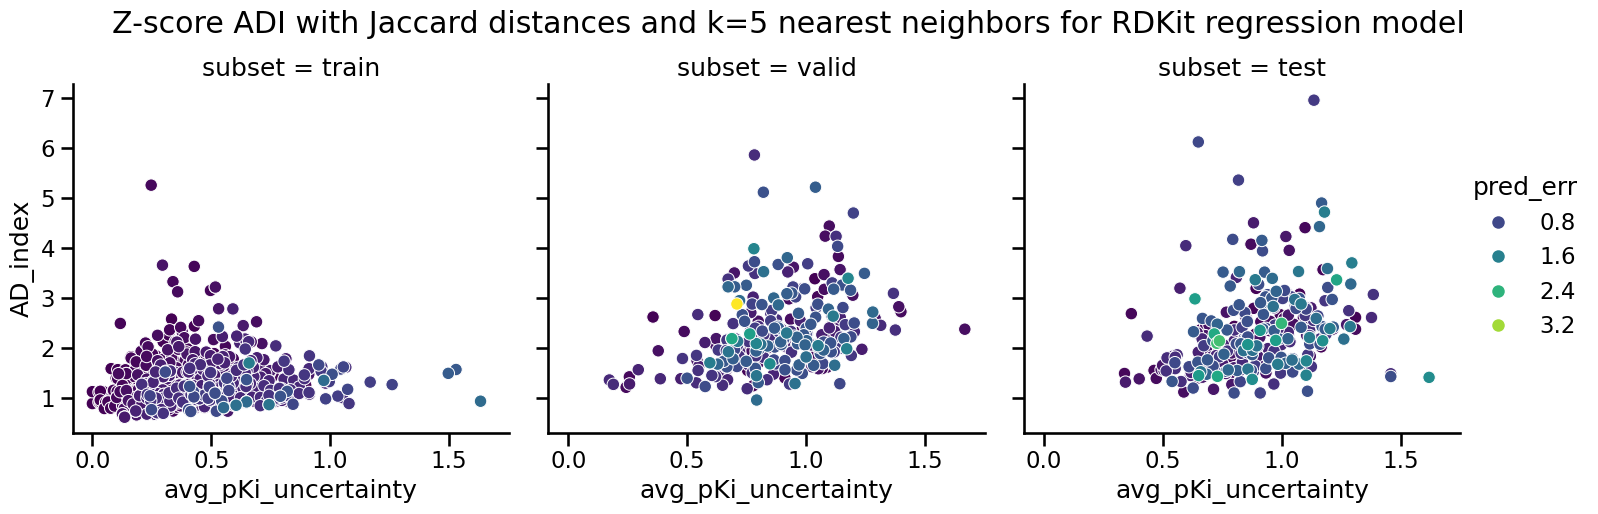

In [93]:
pred_df['pred_err']=abs(pred_df.avg_pKi-pred_df.avg_pKi_pred)
pred_df=pred_df.rename(columns={'avg_pKi_std':'avg_pKi_uncertainty'})
pred_df=pred_df.sort_values(['pred_err']).reset_index(drop=True)

g=sns.relplot(data=pred_df, x='avg_pKi_uncertainty',y='AD_index', hue='pred_err', col='subset', col_order=['train','valid','test'], palette='viridis')
g.fig.suptitle('Z-score ADI with Jaccard distances and k=5 nearest neighbors for RDKit regression model', y=1.04);

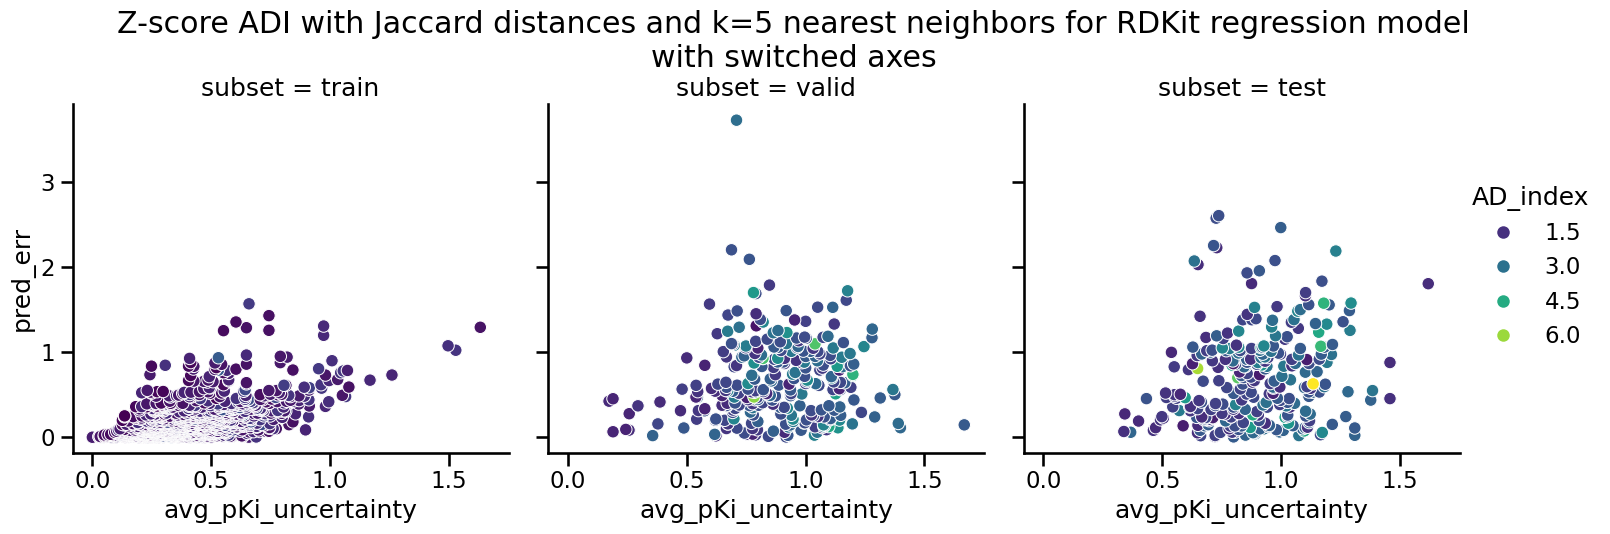

In [96]:
g=sns.relplot(data=pred_df, x='avg_pKi_uncertainty',y='pred_err', hue='AD_index', col='subset', col_order=['train','valid','test'], palette='viridis')
g.fig.suptitle('Z-score ADI with Jaccard distances and k=5 nearest neighbors for RDKit regression model\nwith switched axes', y=1.08);

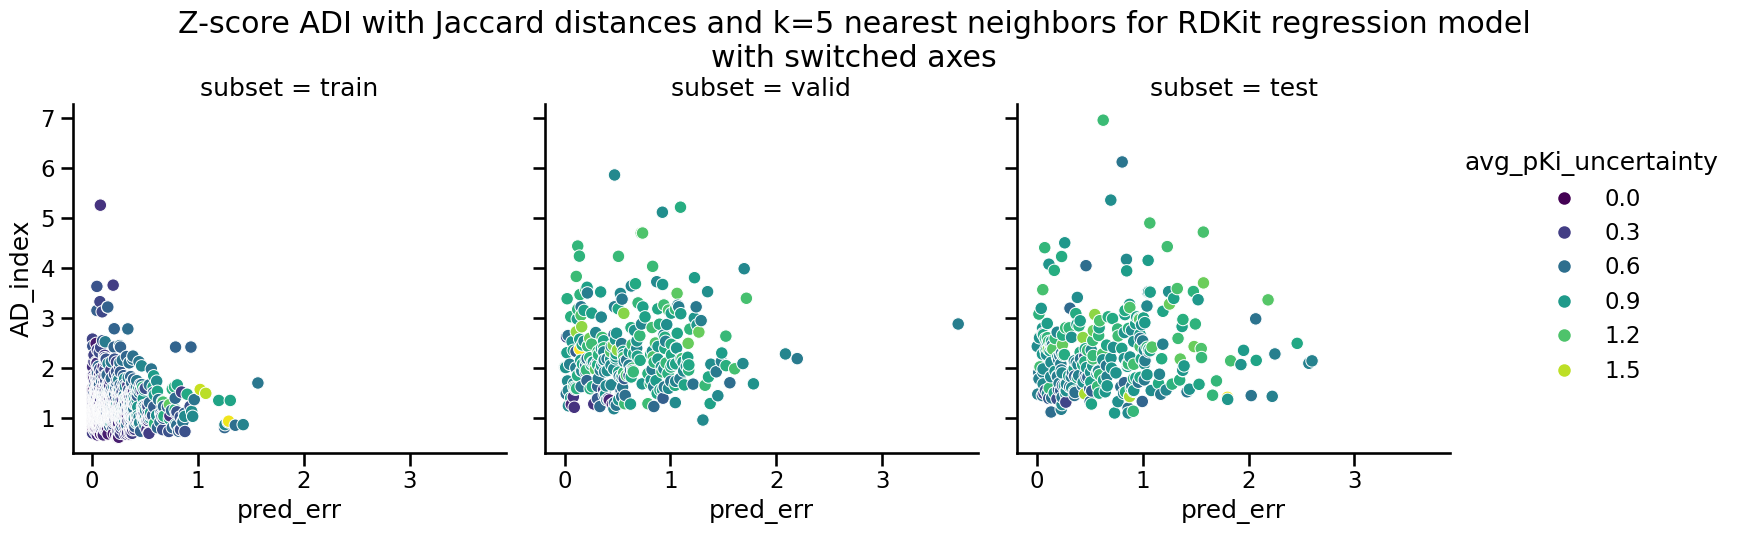

In [97]:
g=sns.relplot(data=pred_df, x='pred_err',y='AD_index', hue='avg_pKi_uncertainty', col='subset', col_order=['train','valid','test'], palette='viridis')
g.fig.suptitle('Z-score ADI with Jaccard distances and k=5 nearest neighbors for RDKit regression model\nwith switched axes', y=1.08);

2024-04-12 18:15:20,147 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
2024-04-12 18:15:20,148 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"
/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/apaulson/atomsci/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


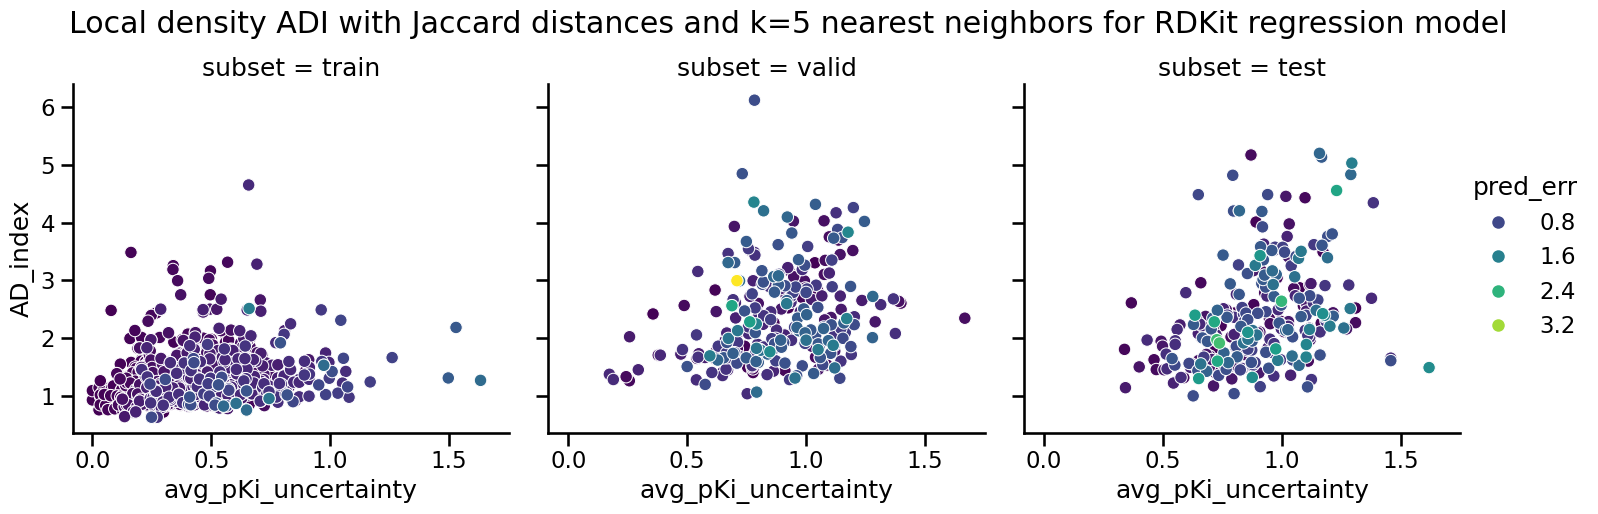

In [98]:
pred_df=pfm.predict_from_model_file(regression_model_path, data, response_col='avg_pKi',
                                    smiles_col='base_rdkit_smiles', dont_standardize=True,
                                    is_featurized=False, 
                                    AD_method='local_density', dist_metric='jaccard', k=5, max_train_records_for_AD=1273)
pred_df['pred_err']=abs(pred_df.avg_pKi-pred_df.avg_pKi_pred)
pred_df=pred_df.rename(columns={'avg_pKi_std':'avg_pKi_uncertainty'})
pred_df=pred_df.sort_values(['pred_err']).reset_index(drop=True)

g=sns.relplot(data=pred_df, x='avg_pKi_uncertainty',y='AD_index', hue='pred_err', col='subset', col_order=['train','valid','test'], palette='viridis')
g.fig.suptitle('Local density ADI with Jaccard distances and k=5 nearest neighbors for RDKit regression model', y=1.04);

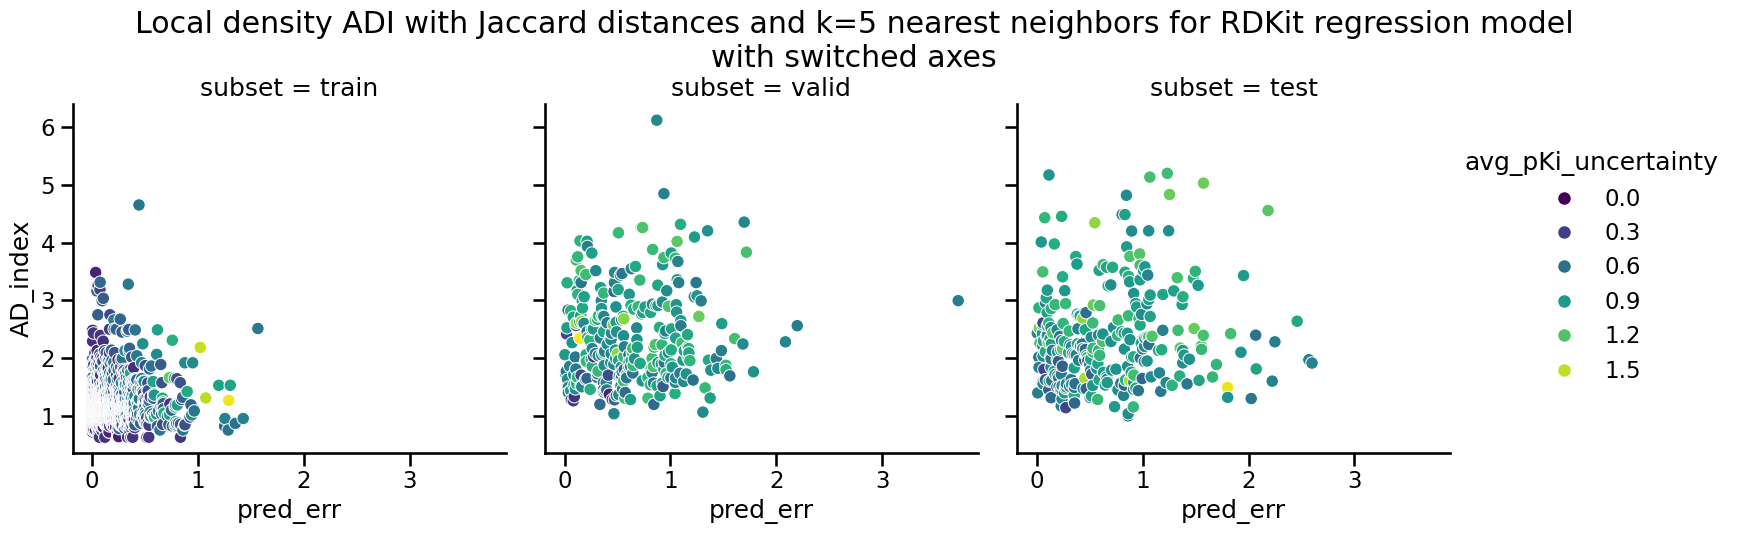

In [99]:
g=sns.relplot(data=pred_df, x='pred_err',y='AD_index', hue='avg_pKi_uncertainty', col='subset', col_order=['train','valid','test'], palette='viridis')
g.fig.suptitle('Local density ADI with Jaccard distances and k=5 nearest neighbors for RDKit regression model\nwith switched axes', y=1.08);

For this regression model, we can see that the uncertainty of the model correlates with the ADI, especially for the Z-score ADI. However, it correlates less well with the actual prediction error. Uncertainty and ADI can shed light on how the model is creating its predictions and are excellent tools to use in order to understand the model's behavior more thoroughly.